In [155]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import pnadcibge_download
import json

sns.set_theme(style="darkgrid")
with open("./RV.json") as f:
    random_variables = json.load(f)

## Auxiliar functions


In [2]:
def plot_dataframe(df: pd.DataFrame, columns: list, format_percentage: bool = False, figsize: tuple = (8, 4)):
    # Se formatar como porcentagem, aplicar em todas as colunas numéricas
    if format_percentage:
        for col in columns:
            if pd.api.types.is_numeric_dtype(df[col]):
                df[col] = df[col].map(lambda x: f"{x:.2f}%")
    
    # Criar a figura
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis('tight')
    ax.axis('off')

    # Resetar o índice para garantir que a tabela apareça com a numeração adequada
    table_data = df[columns].reset_index(drop=True)

    # Criar a tabela com a função plt.table
    table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='center', cellLoc='center', colColours=["#f4f4f4"] * len(columns))

    # Exibir a tabela
    plt.show()

## Download and Extract data

In [3]:
# Download o dicionario e o arquivo de dados pnad
dict_paths = pnadcibge_download.download_data(year=2019, trimestre=3)
# Extrai os dados que vem em um zip
dict_paths = pnadcibge_download.extract_data(paths = dict_paths)

Start download data...
Done!
Starting data extraction... 
Done!


## Convert data to pandas Dataframe

In [4]:
# Cria um dataframe com base nos dados extraidos
df = pnadcibge_download.create_dataframe(
    dict_paths, 
    columns_intrested=list(random_variables.keys()), 
    sample_size=0.10,
    random_seed=221704017,
    clear_files = False
    )
df.to_csv("./pnad_3T19.csv", index= False)

## Manipulando dados

In [166]:
# Lendo o dataframe original
df_original: pd.DataFrame = pd.read_csv("./pnad_3T19.csv")
print(f"Dataframe lido tem {len(df_original)} linhas.")

# Rename columns
dict_col_names = {k: v.get("col_name") for k, v in random_variables.items()}
df_original = df_original.rename(columns = dict_col_names)

for col in df_original.columns:
    if col.startswith("BIN"):
        df_original[col] = df_original[col].replace({2.: 0.})

# Limpando colunas nulas
df_limpo = df_original
print(f"Dataframe dropped na rows tem {len(df_limpo)} linhas")

Dataframe lido tem 55023 linhas.
Dataframe dropped na rows tem 55023 linhas


In [98]:
colunas_null = df_limpo.isnull().sum()
colunas_null = colunas_null[colunas_null > 0]
print(colunas_null)

ORD_NIVEL_FORMACAO             19219
ORD_QTD_EMPREGOS               31747
NOM_MODO_TRABALHO              31747
ORD_TEMPO_ESTUDO                3451
BIN_CONDICAO_FORCA_TRABALHO    10510
BIN_CONDICAO_OCUPACAO          28902
CON_REMUNERACAO_MENSAL         32611
CON_CARGA_HORARIA_SEMANAL      31747
dtype: int64


Nota: apagando linhas que contem NA values, ficamos com um dataframe de aproximadamene 20k linhas, entretanto, nesse caso, todas são pessoas economicamente ativas e, sendo assim, algumas inferências não são possíveis. Partindo desse pressuposto, vamos considerar apenas as varáveis de interesse momentâneas, assumindo que **JAMAIS** todas variáveis vão entrar na regressão, caso isso fosse falso, deveríamos completar os valores faltantes.

Além disso, o resultado acima revela a quantidade de NA values em cada coluna, é inferível que a maior parte desses valores faltantes está assim porque a pessoa pode não ter uma ocupação e, apesar de nesse caso o valor de *BIN_CONDICAO_OCUPACAO* ser 2,  o valor de *CON_CARGA_HORARIA_SEMANAL* é nulo e  essa linha iria sumir, por isso não dá para simplesenta apagar linhas nulas.

Adicionaremos uma coluna indicando os dados categóricos de nível de formação com seus respectivos nomes.

Por fim, tendo em mente as colunas com variáveis binárias e seus valores:
- *BIN_CONDICAO_FORCA_TRABALHO*: 1 para pessoa na força de trabalho e 2 para pessoa fora da força de trabalho;
- *BIN_CONDICAO_OCUPACAO*: 1 para pessoa ocudapadas e 2 para pessoas desocupadas;
- *BIN_ZONA_DOMICILIO*: 1 para Urbana e 2 para Rural;
- *BIN_SEXO*: 1 Homem e 2 Mulher.

Vamos fazer o replace de 2 por 0, assim, reduzimos a linha de base para pessoas fora da força de trabalho, desocupadas, em domicilio rural ou mulheres, ficando extremamente nítido o que significa o coeficiente da regressão.

In [170]:
dict_niveis_formacao = {
    2:	"Pré-escola",
    3:	"Classe de alfabetização",
    4:	"Alfabetização de jovens e adultos",
    5:	"Antigo primário (elementar)",
    6:	"Antigo ginásio (médio 1º ciclo)",
    7:	"Regular do ensino fundamental",
    8:	"EJA ou supletivo do 1º grau",
    9:	"Antigo científico (médio 2º ciclo)",
    10:	"Regular do ensino médio",
    11:	"EJA ou supletivo do 2º grau",
    12:	"Superior - graduação",
    13:	"Especialização nível superior",
    14:	"Mestrado",
    15:	"Doutorado",
}

ordem_categorica = list(dict_niveis_formacao.values())


# Converter para uma categoria ordenada
df_limpo["VALUES_NIVEL_FORMACAO"] = pd.Categorical(
    df_limpo["ORD_NIVEL_FORMACAO"].replace(dict_niveis_formacao), 
    categories=ordem_categorica, 
    ordered=True)

### Proporções população economicamente ativa

In [171]:
mask_age = (df_limpo["CON_IDADE"] >= 20) & (df_limpo["CON_IDADE"] <= 60)
mask_economicamente_ativo = df_limpo["ORD_QTD_EMPREGOS"].notna()
df_by_age_ativos = df_limpo[mask_economicamente_ativo & mask_age]
df_economicamente_ativos = df_limpo[mask_economicamente_ativo]

#### Vs nível de formação

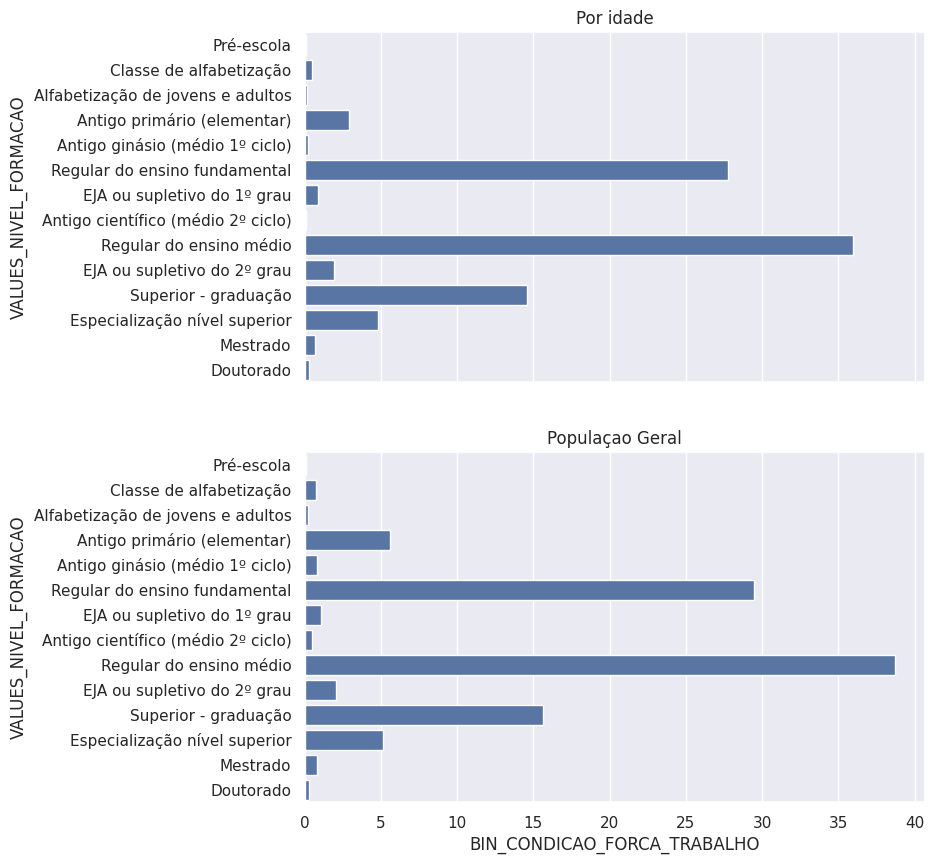

In [181]:

df_nv_formacao = df_by_age_ativos[["VALUES_NIVEL_FORMACAO", "BIN_CONDICAO_FORCA_TRABALHO"]]

fig, axes = plt.subplots(nrows=2, figsize=(8, 10), sharex=True, sharey=True)

sns.barplot(data = df_nv_formacao, 
            y="VALUES_NIVEL_FORMACAO", 
            x="BIN_CONDICAO_FORCA_TRABALHO", 
            orient="h",
            estimator = lambda x: x.sum() * 100/ len(df_by_age_ativos), ax=axes[0]).set_title("Por idade")

sns.barplot(data= df_economicamente_ativos,
            y="VALUES_NIVEL_FORMACAO", 
            x="BIN_CONDICAO_FORCA_TRABALHO", 
            orient="h",
            estimator = lambda x: x.sum() * 100/ len(df_by_age_ativos), ax=axes[1]).set_title("Populaçao Geral")

plt.show()

/tmp/ipykernel_8049/1971730235.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_tabela = df_nv_formacao.groupby("VALUES_NIVEL_FORMACAO")["BIN_CONDICAO_FORCA_TRABALHO"].sum()


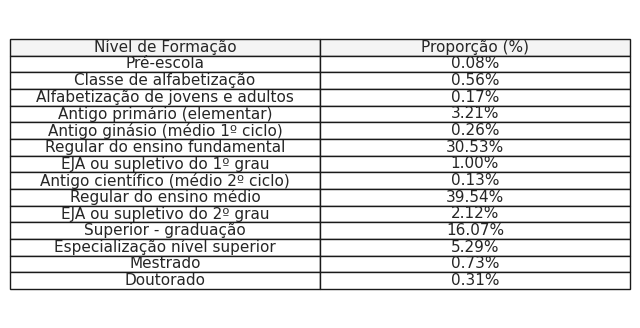

In [183]:
df_tabela = df_nv_formacao.groupby("VALUES_NIVEL_FORMACAO")["BIN_CONDICAO_FORCA_TRABALHO"].sum()
df_tabela = (df_tabela / df_tabela.sum()) * 100
df_tabela = df_tabela.map(lambda x: f"{x:.2f}%")
# Criar a figura
fig, ax = plt.subplots(figsize=(8, 4))  # Ajuste o tamanho conforme necessário
ax.axis('tight')
ax.axis('off')

# Plotar a tabela no gráfico
table_data = df_tabela.reset_index()
table_data.columns = ['Nível de Formação', 'Proporção (%)']  # Adicionar rótulos às colunas

# Criar a tabela com a função plt.table
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='center', cellLoc='center', colColours=["#f4f4f4"]*2)

# Exibir a tabela
plt.show()

#### Vs Idade

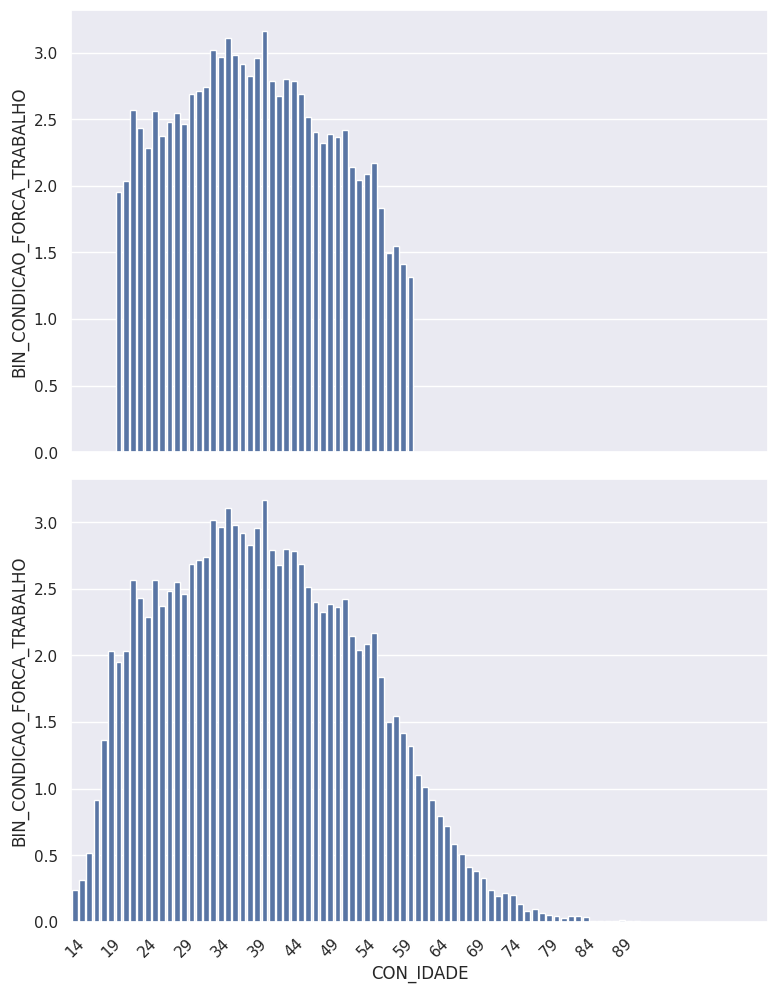

In [194]:
fig, axes = plt.subplots(nrows=2, figsize=(8, 10), sharex=True)


sns.barplot(data = df_economicamente_ativos, 
            x="CON_IDADE", 
            y="BIN_CONDICAO_FORCA_TRABALHO", 
            orient="v",
            estimator = lambda x: x.sum() * 100/ len(df_by_age_ativos),
            ax=axes[1])

sns.barplot(data = df_by_age_ativos, 
            x="CON_IDADE", 
            y="BIN_CONDICAO_FORCA_TRABALHO", 
            orient="v",
            estimator = lambda x: x.sum() * 100/ len(df_by_age_ativos),
            ax=axes[0])

fig.tight_layout()
plt.xticks([i for i in range(100) if i %5 == 0], rotation=45)
plt.show()

/tmp/ipykernel_8049/1917997741.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_tabela = df_by_age_ativos.groupby("FAIXA_IDADE")["BIN_CONDICAO_FORCA_TRABALHO"].sum()


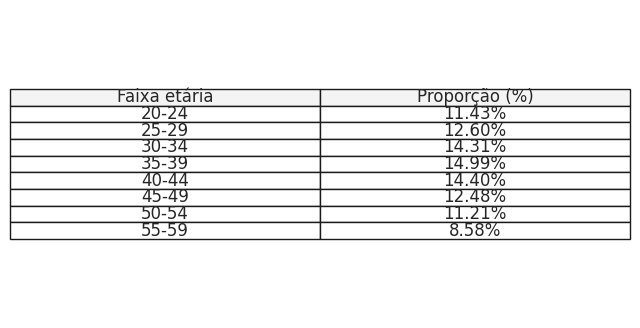

In [195]:
# Criar faixas de 5 em 5 anos para a coluna CON_IDADE
faixas_idade = pd.cut(df_by_age_ativos["CON_IDADE"], 
                      bins=range(20, 65, 5),  # Definindo as faixas de 5 em 5 anos (20 a 60)
                      right=False,  # Para incluir a faixa inicial, mas não a final
                      labels=[f"{i}-{i+4}" for i in range(20, 60, 5)])

# Adicionar a coluna de faixas de idade ao DataFrame
df_by_age_ativos["FAIXA_IDADE"] = faixas_idade

# Agrupar por faixa de idade e calcular a soma de BIN_CONDICAO_FORCA_TRABALHO
df_tabela = df_by_age_ativos.groupby("FAIXA_IDADE")["BIN_CONDICAO_FORCA_TRABALHO"].sum()

# Converter para porcentagem
df_tabela = (df_tabela / df_tabela.sum()) * 100

# Formatar os valores como porcentagem
df_tabela = df_tabela.map(lambda x: f"{x:.2f}%")

fig, ax = plt.subplots(figsize=(8, 4))  # Ajuste o tamanho conforme necessário
ax.axis('tight')
ax.axis('off')

# Plotar a tabela no gráfico
table_data = df_tabela.reset_index()
table_data.columns = ['Faixa etária', 'Proporção (%)']  # Adicionar rótulos às colunas

# Criar a tabela com a função plt.table
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='center', cellLoc='center', colColours=["#f4f4f4"]*2)

# Exibir a tabela
plt.show()

#### Vs Sexo

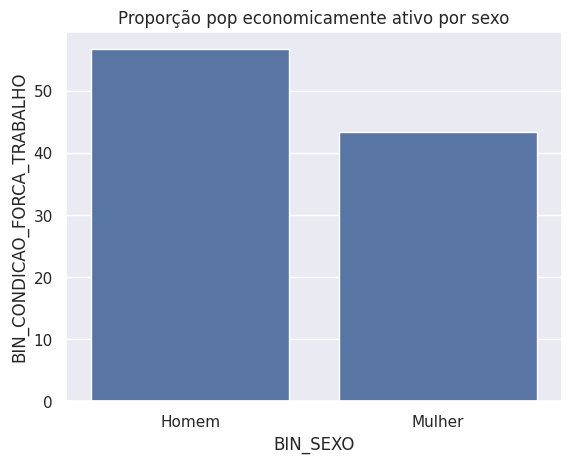

In [206]:
dict_replace_sexo = {
    1.: "Homem",
    0.: "Mulher"
}

df_economicamente_sexo = df_by_age_ativos[["BIN_SEXO", "BIN_CONDICAO_FORCA_TRABALHO"]].copy()
df_economicamente_sexo["BIN_SEXO"] = df_economicamente_sexo["BIN_SEXO"].replace(dict_replace_sexo)

sns.barplot(data = df_economicamente_sexo, 
            x="BIN_SEXO", 
            y="BIN_CONDICAO_FORCA_TRABALHO", 
            orient="v",
            estimator = lambda x: x.sum() * 100/ len(df_economicamente_sexo))
plt.title("Proporção pop economicamente ativo por sexo")
plt.show()

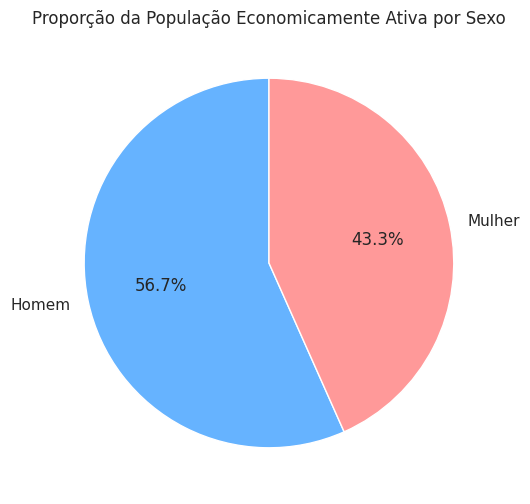

In [207]:
proporcoes = df_economicamente_sexo.groupby("BIN_SEXO")["BIN_CONDICAO_FORCA_TRABALHO"].sum()
proporcoes = proporcoes * 100 / len(df_economicamente_sexo)  # Converter para porcentagem

# Criar o gráfico de pizza
plt.figure(figsize=(6,6))
plt.pie(proporcoes, labels=proporcoes.index, autopct='%1.1f%%', colors=["#66b3ff", "#ff9999"], startangle=90)
plt.title("Proporção da População Economicamente Ativa por Sexo")

plt.show()

### Estatísticas variáveis contínuas 

Coluna **NOM_MODO_TRABALHO**
- 1: Trabalhador doméstico
- 2: Militar do exército, da marinha, da aeronáutica, da polícia militar ou do corpo de bombeiros militar
- 3: Empregado do setor privado
- 4: Empregado do setor público (inclusive empresas de economia mista)
- 5: Empregador
- 6: Conta própria
- 7: Trabalhador familiar não remunerado

In [208]:
col_rvs_continuas = list()
col_rvs_discretas = list()
for col in df_limpo.columns: 
    if col.startswith("CON_"):
        col_rvs_continuas.append(col)
    else:
        col_rvs_discretas.append(col)


##### Descrição RVS continuas

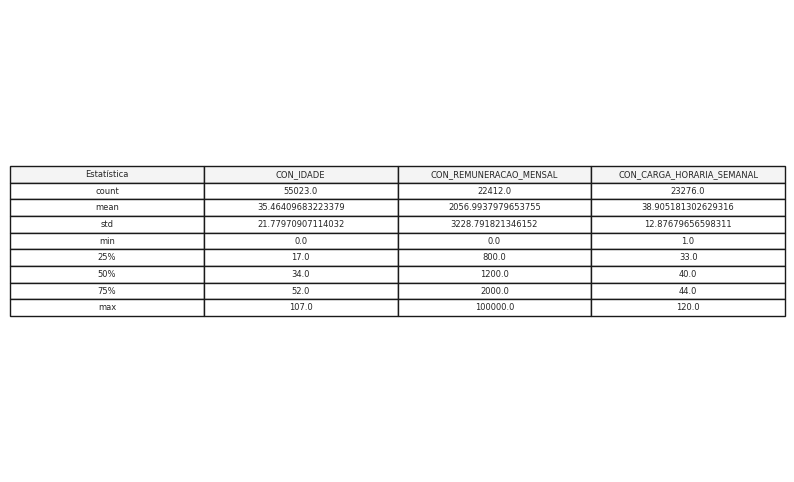

In [150]:

df_description_continue_rvs = df_limpo[col_rvs_continuas].describe()

# Criar a figura
fig, ax = plt.subplots(figsize=(10, 6))  # Ajuste o tamanho conforme necessário
ax.axis('tight')
ax.axis('off')

# Plotar a tabela com a função plt.table
table_data = df_description_continue_rvs.reset_index()
table_data.columns = ['Estatística'] + list(df_description_continue_rvs.columns)

# Criar a tabela com a função plt.table
table = ax.table(cellText=table_data.values, colLabels=table_data.columns, loc='center', cellLoc='center', colColours=["#f4f4f4"] * len(table_data.columns))

# Salvar como imagem
plt.savefig("tabela_describe.png", bbox_inches='tight', dpi=300)

# Exibir a tabela
plt.show()

##### Descrição RVS Discretas

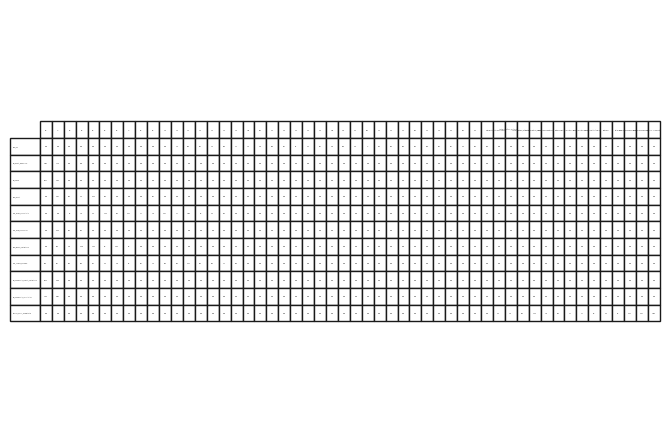

In [215]:
tabela_dict = dict()

for col in col_rvs_discretas:
    tabela_dict[col] = (df_limpo[col].value_counts(normalize=True) * 100).round(2)

# Criar um DataFrame a partir do dicionário
df_tabela = pd.DataFrame(tabela_dict).transpose()

# Criar a figura para exibir a tabela
fig, ax = plt.subplots(figsize=(8, len(df_tabela) * 0.5))  # Ajustar altura dinamicamente
ax.axis("tight")
ax.axis("off")
table = ax.table(cellText=df_tabela.values, 
                 colLabels=df_tabela.columns, 
                 rowLabels=df_tabela.index, 
                 cellLoc="center", 
                 loc="center")

# Salvar como imagem
plt.savefig("tabela_discretas.png", dpi=300, bbox_inches="tight")

# Exibir a imagem
plt.show()


O problema caso uma variável tivesse todas observações iguais seria não conseguir visualizar o efeito dela na variável dependente, visto que não teriamos informação sobre outros valores/grupos

#### Regressão salário

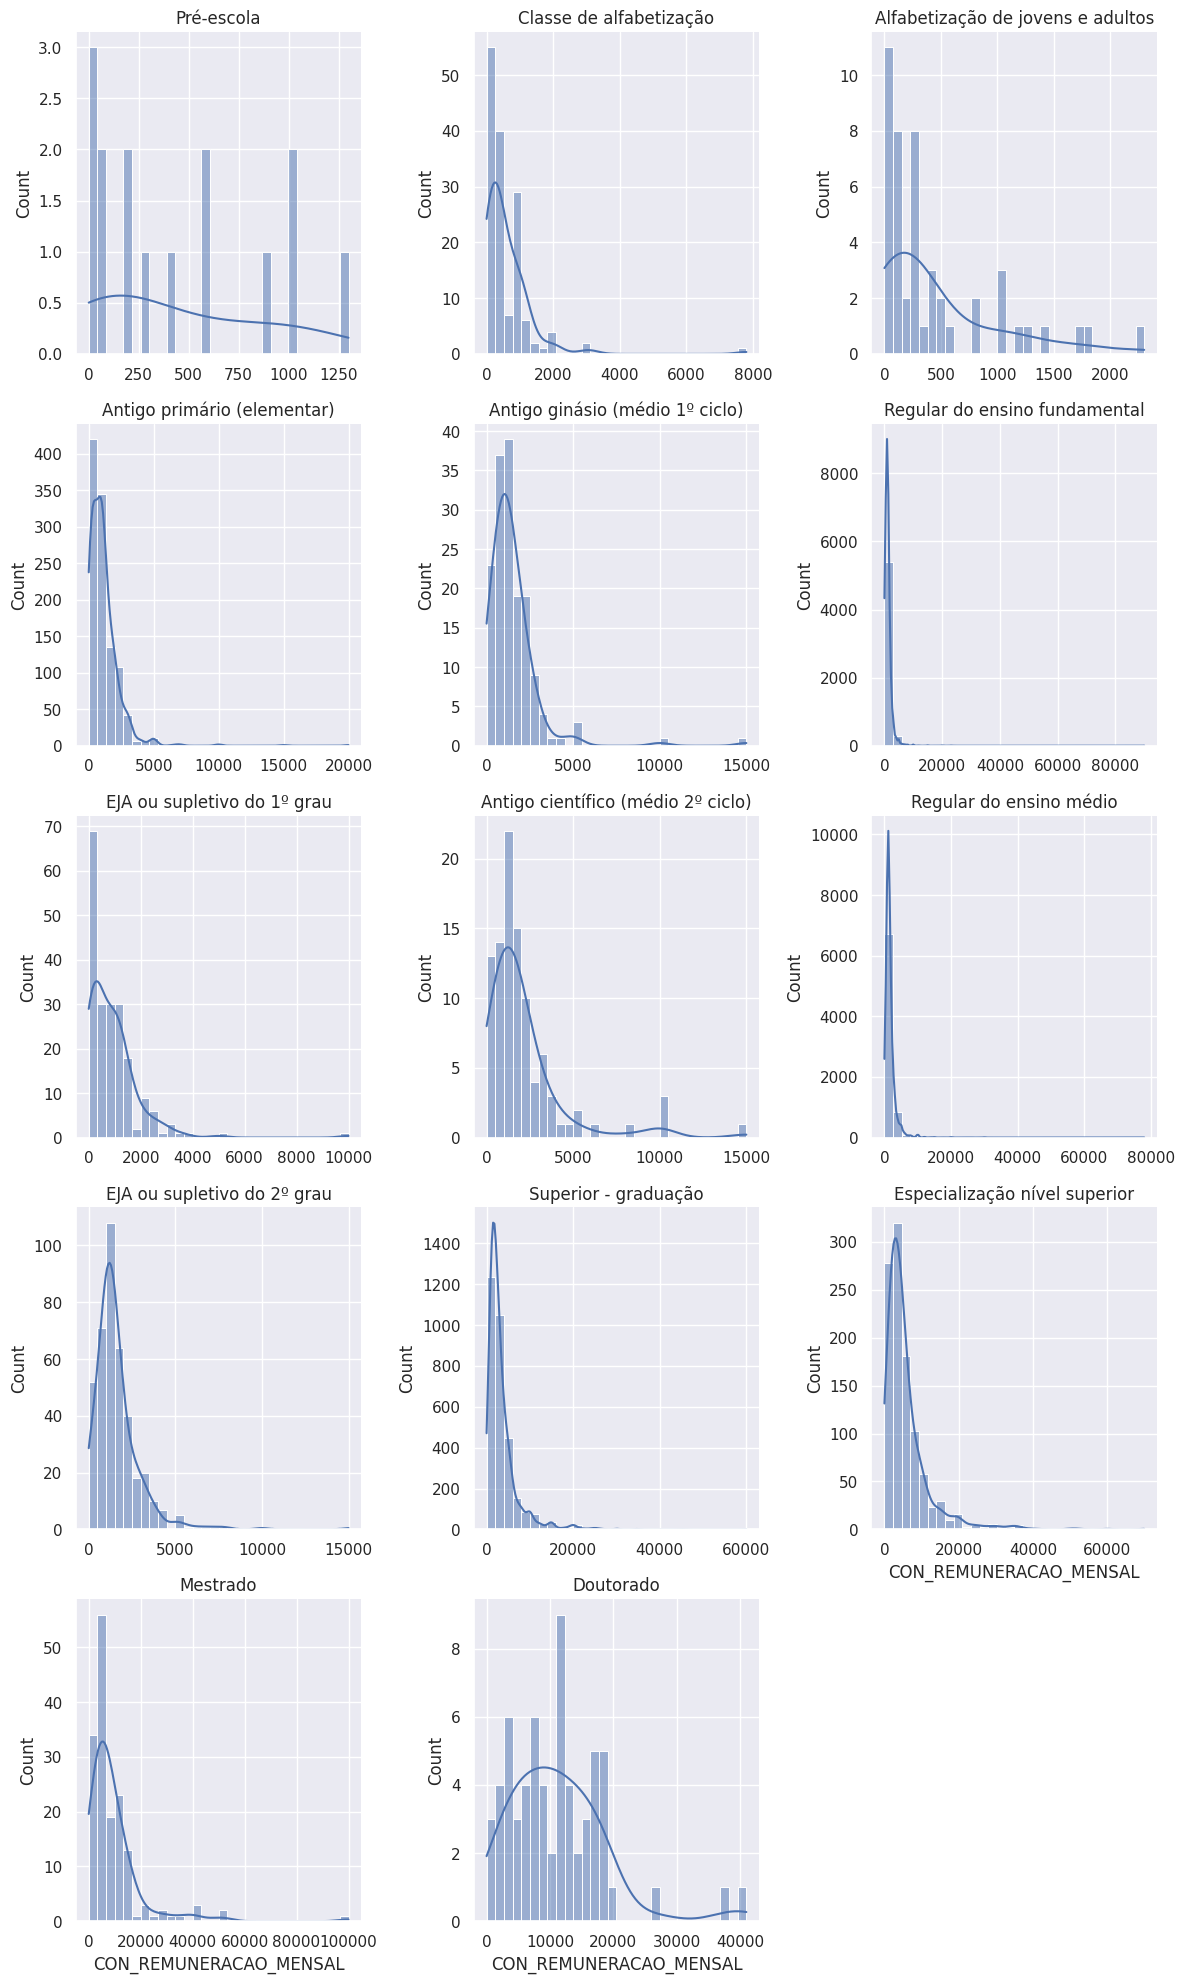

In [210]:
g = sns.FacetGrid(df_limpo, col="VALUES_NIVEL_FORMACAO", col_wrap=3, height=4, sharex=False, sharey=False)
g.map_dataframe(sns.histplot, x="CON_REMUNERACAO_MENSAL", bins=30, kde=True)

g.set_titles("{col_name}")
plt.show()

/home/lucasfelipe/Documents/trabalho_econometria/venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


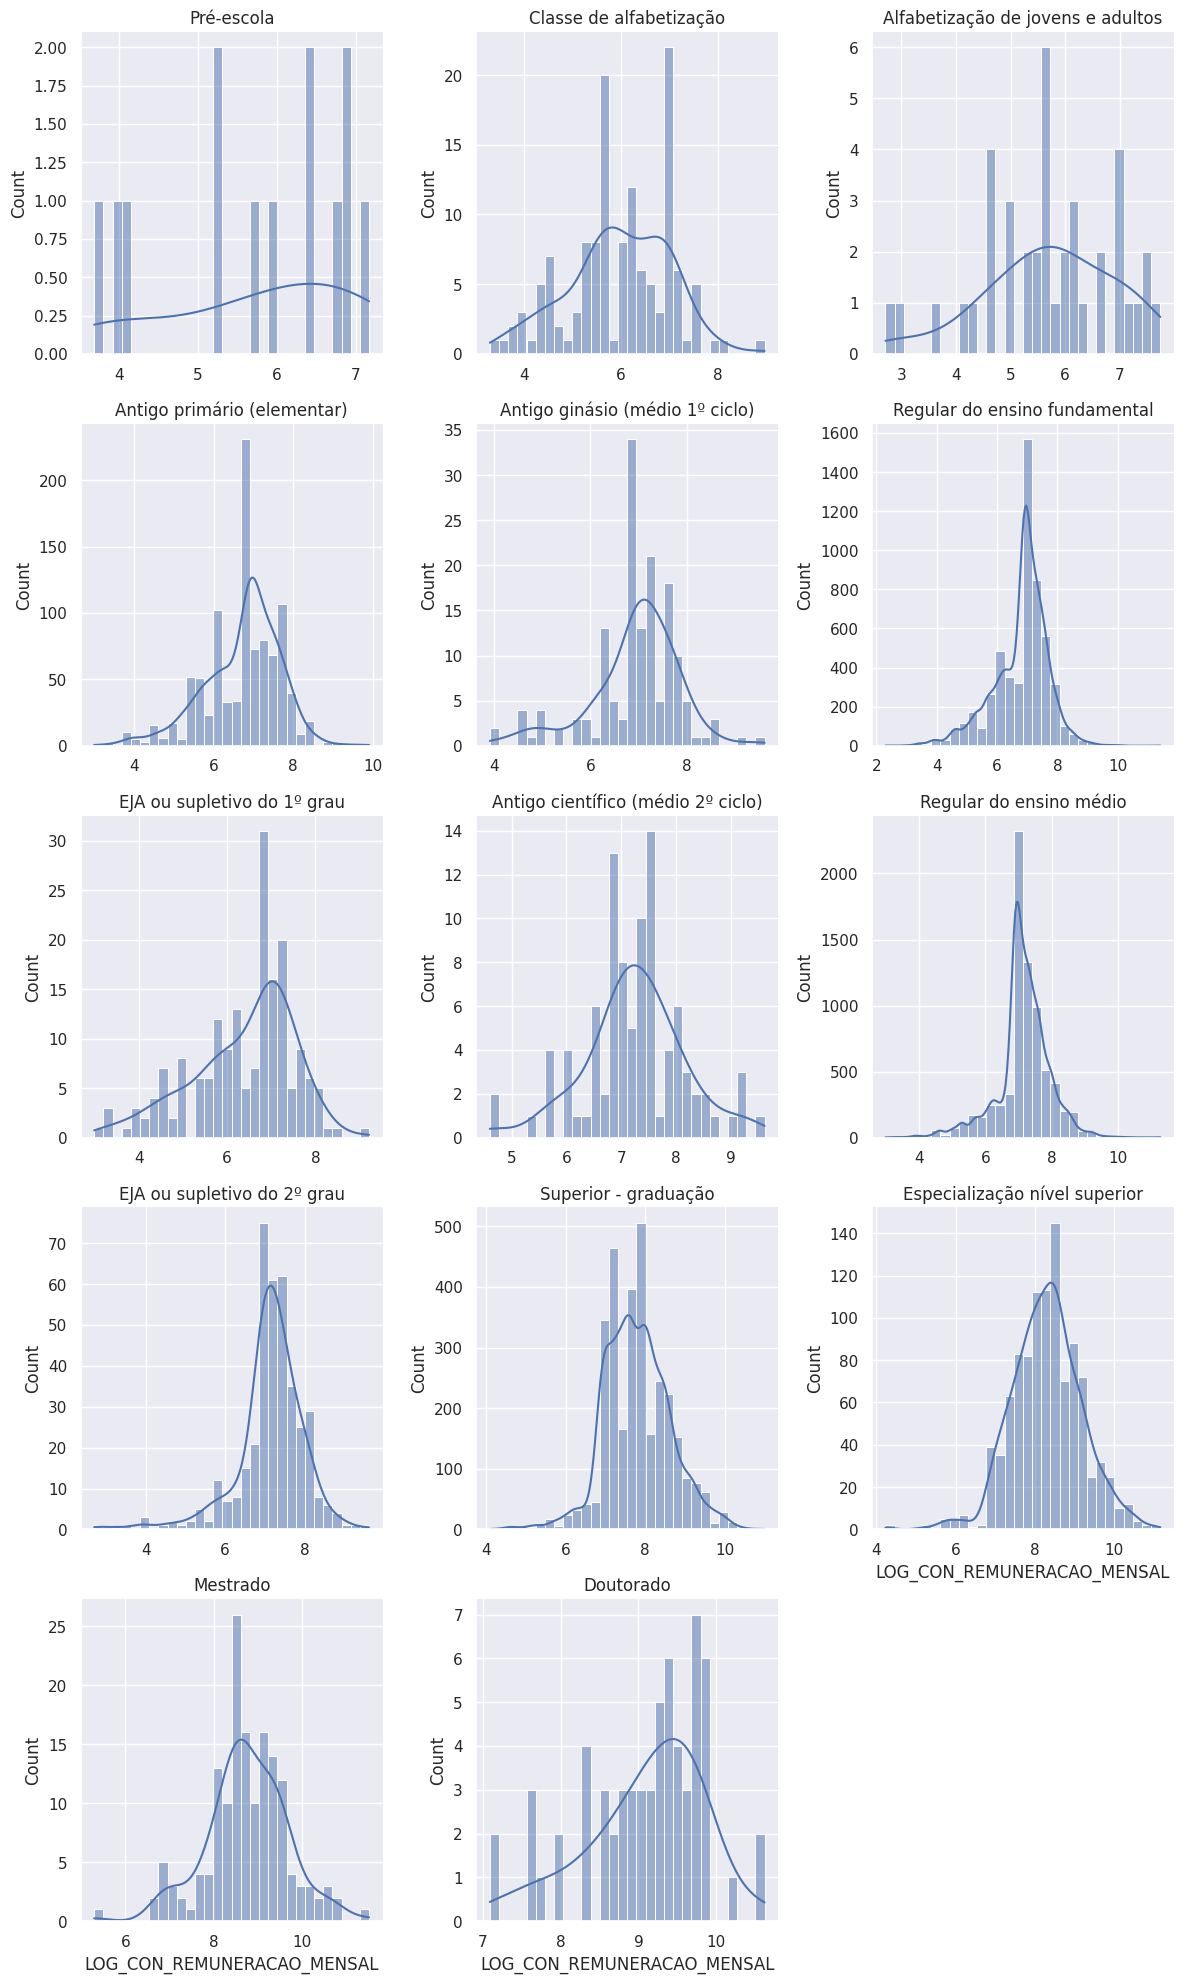

In [213]:
df_limpo["LOG_CON_REMUNERACAO_MENSAL"] = np.log(df_limpo["CON_REMUNERACAO_MENSAL"])

g = sns.FacetGrid(df_limpo, col="VALUES_NIVEL_FORMACAO", col_wrap=3, height=4, sharex=False, sharey=False)
g.map_dataframe(sns.histplot, x="LOG_CON_REMUNERACAO_MENSAL", bins=30, kde=True)

g.set_titles("{col_name}")
plt.show()